# 路径规划实现
# 《各自为政，分而治之》
1. 读取Excel文件，提取X坐标和Y坐标
2. 使用K-means算法对坐标信息进行聚类，得到jichao和dianwei_list列表。分别代表生成的机巢点位，和每个机巢所负责的待巡检杆塔点位。
3. 构造每个分区的巡检策略函数。

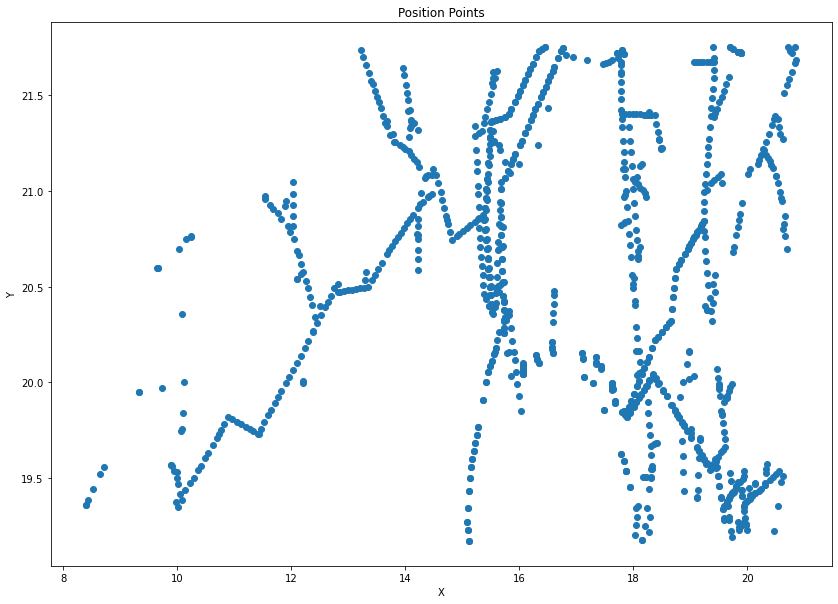

In [1]:
# 1. 读取.xlsx文件内杆塔作为信息
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=20)

# 读取Excel文件，提取X坐标和Y坐标
data = pd.read_excel('./Samples/杆塔数据样例1.xlsx', dtype=np.float64)
X = data.iloc[:, 1:3].values


# 展示

fig, ax = plt.subplots(figsize=(14, 10))   # 创建画布和子图，设置图像大小
ax.scatter(X[:, 0], X[:, 1])   # 绘制散点图
# 添加点的编号
# for i, txt in enumerate(data.iloc[:, 0]):
#     ax.annotate(txt, X[i], textcoords="offset points", xytext=(0, 10), ha='center')
plt.title('Position Points')   # 设置图像标题和坐标轴标签
plt.xlabel('X')
plt.ylabel('Y')
plt.show()# 显示图像

F:\miniconda\envs\torch_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


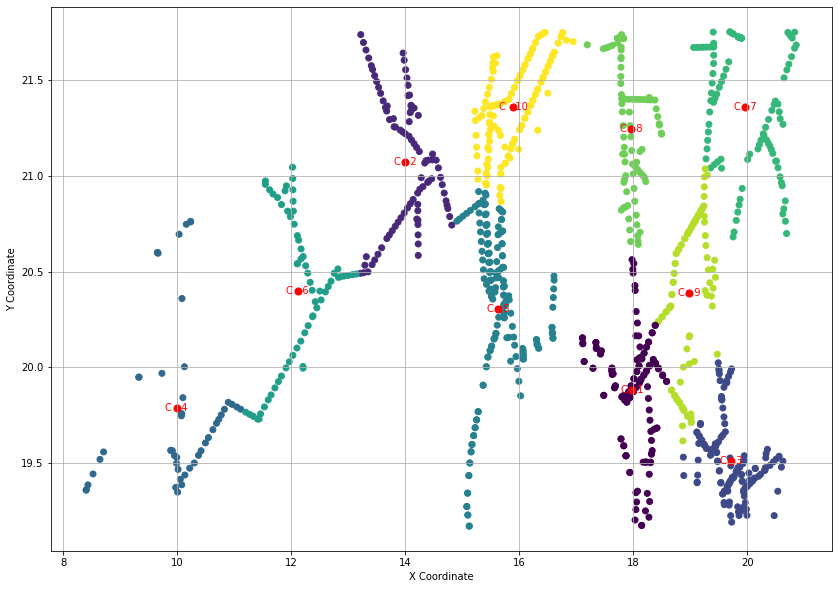

Cluster 1 Center: (17.984396861647443, 19.880490905389223)
Cluster 2 Center: (14.00022813041514, 21.073903851030526)
Cluster 3 Center: (19.72480218407298, 19.510831969742643)
Cluster 4 Center: (9.989013518526933, 19.787730858000394)
Cluster 5 Center: (15.625446064561144, 20.30759859227999)
Cluster 6 Center: (12.11497208145055, 20.399841003031998)
Cluster 7 Center: (19.967887862270878, 21.3612704936863)
Cluster 8 Center: (17.965060730111386, 21.24773465452688)
Cluster 9 Center: (18.97934616115267, 20.389270262393755)
Cluster 10 Center: (15.893170146476827, 21.361224699845774)


In [2]:
# 2. 使用K-means算法对坐标信息进行聚类，得到10个飞机巢位置点
from sklearn.cluster import KMeans
# 使用K-means算法进行聚类
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X)

# 获取聚类中心坐标，即为机巢坐标
jichao = kmeans.cluster_centers_


# 展示
fig, ax = plt.subplots(figsize=(14, 10))   # 创建画布和子图，设置图像大小
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis')

# 绘制聚类中心
plt.scatter(jichao[:, 0], jichao[:, 1], marker='o', color='red', s=50)
# 添加标签
for i, center in enumerate(jichao):
    plt.text(center[0], center[1], f"C   {i+1}", color='red', ha='center', va='center')

# 设置坐标轴标签
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# 显示网格线和图像
plt.grid(True)
plt.show()


# 输出每个聚类中心的坐标---------即要求的机巢选址策略
for i, center in enumerate(jichao):
    print(f"Cluster {i+1} Center: ({center[0]}, {center[1]})")

# 机巢生成完成！下面对分别每个机巢的巡检顺序进行规划

In [3]:
# 生成一个点位列表，内涵10个子列表，为10类聚类结果，每个子列表的第一项为聚类中心（机巢坐标，位置号为0）
dianwei_list = [[[0, [x, y]]] for x, y in jichao.tolist()]
for i, label in enumerate(kmeans.labels_):
    dianwei_list[label].append([int(i+1), [X[i][0], X[i][1]]])  # 为列表逐个增加第i类聚类的坐标
print(len(dianwei_list[1]))
# dianwei_list[8]

90


In [4]:
# 这边处理几号机巢，下面就生成几号机巢的路径。
# 由于generate_route返回的路径编号是相对的，在保存时需要转化为原始的绝对坐标。
def process_list(my_list):
    count_dict = {}
    coordinate = []
    
    for i, item in enumerate(my_list):
        count_dict[i] = item[0]
        coordinate.append(item[1])
    return count_dict, coordinate


count_dict, coordinate = process_list(dianwei_list[8])

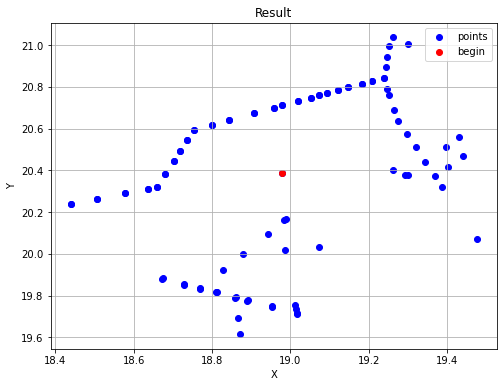

In [5]:
# 计算2个点之间的距离
def calculate_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

# 生成路径(一次规划一个机巢)：输入为需要巡检的坐标列表和最大行驶里程
def generate_route(points, max_distance):
    remaining_points = set(range(len(points)))
    remaining_points.remove(0)   # 还没巡检的位置集合（去除起始位置）
    route = []
    current_point = 0
    distance_traveled = 0

    # 当还有剩余点位未能巡检
    while remaining_points:
        
        # 找到最近点的序号，并计算当前位置到最近的点距离
        nearest_point = min(remaining_points, key=lambda x: calculate_distance(points[current_point], points[x]))
        distance_to_nearest = calculate_distance(points[current_point], points[nearest_point])
        # print(distance_to_nearest)

        # 最近的点到机巢距离
        distance_to_nest = calculate_distance(points[nearest_point], points[0])
        
        # 当已经行驶的距离+飞到最近点位的距离+能飞回巢穴的距离 小于  最大里程
        if distance_traveled + distance_to_nearest + distance_to_nest <= max_distance:
            route.append(nearest_point)
            remaining_points.remove(nearest_point)
            current_point = nearest_point
            distance_traveled += distance_to_nearest
        else:
            # 返回起点加油
            route.append(0)
            current_point = 0
            distance_traveled = 0
        # print(route)

    # 添加回到起始点的路径
    route.append(0)
    return route

# 示例用法
points = np.array(coordinate)  # 待巡检点的坐标
max_distance = 5  # 最大行驶距离
route = generate_route(points, max_distance)

# 可视化路径规划结果
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], color='blue', label='points')
plt.scatter(points[0, 0], points[0, 1], color='red', label='begin')
# plt.plot(points[route, 0], points[route, 1], color='green', linestyle='-', marker='o', label='航线')
# plt.plot(points[route[:2], 0], points[route[:2], 1], color='green', linestyle='-', marker='o')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Result')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
def save_to_text_file(my_list, file_name, dic):
    i = 1
    with open(file_name, 'w') as file:
        file.write(str(i) + ' ')
        for item in my_list:
            if item == 0:
                i = i+1
                file.write(' '+'b'+'\n' + str(i))  # 遇到0时换行
            else:
                file.write(' ' + str(dic[item]))  # 写入列表内容并用空格分隔
        file.write(' '+'b')
        
# 调用保存函数，一次保存一个机巢对应的路径。
dic = count_dict
save_to_text_file(route, '机巢.txt', dic)